In [197]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
import matplotlib.pyplot as plt

In [248]:
tickerStrings = ['BTI', 'PM','EV']
for ticker in tickerStrings:
    data = yf.download(ticker, group_by="Ticker", start='2010-1-1',end='2020-11-06')
    data['ticker'] = ticker  # add this column becasue the dataframe doesn't contain a column with the ticker
    data.to_csv(f'ticker_{ticker}.csv')  # ticker_AAPL.csv for example
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [285]:
df_bti=pd.read_csv('ticker_BTI.csv')
df_pm=pd.read_csv('ticker_PM.csv')
df_ev=pd.read_csv('ticker_ev.csv')

In [290]:
#manipulate df's
df_ev_close=df_ev['Date'],df_ev['Close']
df_ev_close=pd.DataFrame(df_ev_close)
df_ev_close=df_ev_close.T
df_bti_close=df_bti['Close']
df_pm_close=pd.DataFrame(df_bti_close)
df_bti_close=df_bti_close
df_pm_close=df_pm['Close']
df_pm_close=pd.DataFrame(df_pm_close)
df_pm_close=df_pm_close

In [287]:
full_df_close=pd.concat([df_ev_close,df_pm_close,df_bti_close],axis=1)

In [288]:
full_df_close['Date']=full_df_close['Date'].astype('datetime64[ns]')
full_df_close.set_index('Date',inplace=True)

In [289]:
full_df_close

,Close,Close,Close
Date,,,
2010-01-04,30.87,49.349998,32.605000
2010-01-05,30.8,48.919998,32.570000
2010-01-06,31.26,48.919998,32.465000
2010-01-07,31.73,49.529999,32.685001
2010-01-08,31.8,49.259998,32.505001
...,...,...,...
2020-10-30,59.79,71.629997,32.220001
2020-11-02,60.43,71.820000,32.650002
2020-11-03,61.47,71.540001,33.259998


In [291]:
monthly_df = full_df_close.resample('M').first()

# calc daily return
returns_daily = full_df_close.pct_change()


# calc monthly return
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.head())

               Close     Close     Close
Date                                    
2010-02-28 -0.049887 -0.065653  0.013188
2010-03-31  0.055574  0.061158  0.035266
2010-04-30  0.095930  0.072348  0.025439
2010-05-31  0.052756 -0.058129 -0.096806
2010-06-30 -0.179171 -0.110279 -0.034886


In [292]:
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:
    # mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    #  mask to get daily returns for the current month and year of monthly returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

          Close     Close     Close
Close  0.000034 -0.000003  0.000063
Close -0.000003  0.000025  0.000053
Close  0.000063  0.000053  0.000268


In [293]:
#storing rtrn,vol, weight as dict
portfolio_returns, portfolio_volatility, portfolio_weights={},{},{}
# port performance for most recent
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(1000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.31194609 0.36714842 0.3209055 ]


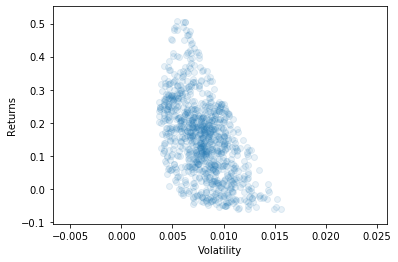

In [294]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]

# plot efficient frontier

plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [295]:
#not perfect

In [298]:
# empty dicti for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # getting shaprpe | divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.4882107355702904


In [299]:
#weak sharpe ratio

In [302]:
# calc exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# resample daily returns to first business day of month
ewma_monthly = ewma_daily.resample('M').first()

# shift ewma for the month  fwd one mnonth to use as feature on predicctions 
ewma_monthly = ewma_monthly.shift().dropna()

print(ewma_monthly.iloc[-1])

Close    0.000587
Close   -0.002507
Close    0.001082
Name: 2020-11-30 00:00:00, dtype: float64


In [303]:
targets, features = [], []

# create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # get best sharpe by index
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # adding ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.91903224 0.04345318 0.03751458]
 [0.05010651 0.91427835 0.03561513]
 [0.43650521 0.44466284 0.11883195]
 [0.00723252 0.00568277 0.98708471]
 [0.86652969 0.12684874 0.00662158]]


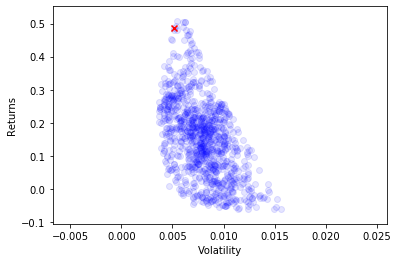

In [304]:
# get most recent returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# red X is best sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='red')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [306]:
#not enough risk

In [305]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8267992273691382
-0.20817634331718357


C:\Users\Dan\Anaconda3\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\Dan\Anaconda3\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "m

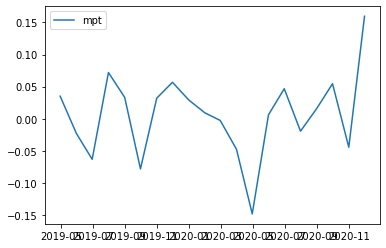

In [309]:
# predict on random forest model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# plotting returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='mpt')

plt.legend()
plt.show()

In [310]:
#returns aren't beating bench

In [311]:
# what 10k invested would look like
cash = 10000
mpt_cash = [cash]
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)
print('mpt returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])


mpt returns: 0.08593404580245079


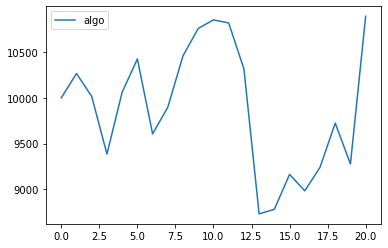

In [284]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash,label='algo')

plt.legend()  # show the legend
plt.show()